<h1 style="text-align: center; font-size:2.5em;"> Assignment 2 </h1>

# <u> Part 1: Twitter Network Analysis</u>

### <i> Exercise 1: Build the network of retweets.</i>

We will now build a network that has as nodes the Twitter handles of the members of the house, and direct edges between nodes A and B if A has retweeted content posted by B. We will build a weighted network, where the weight of an edge is equal to the number of retweets.

In [1]:
import networkx as nx
import pandas as pd
import os
import re
import io

- First, we go through all the files (provided in the Repository of the course) and add a node per congressman.

In [2]:
path = 'data/tweets/'

#Directed graph
rt_graph = nx.DiGraph()

#Undirected graph.
#Useful in future exercises
rt_nonDirgraph = nx.Graph()

#Relation Twitter profile to Party
tw_parties = pd.read_csv('./data/H115_tw.csv')

for file in os.listdir(path):
    # Include the member we are analysing to the network
    rt_graph.add_node(file,
                      party=tw_parties[tw_parties.tw_name == file].Party,
                      betrayals=0#rt to other party
                     )
    rt_nonDirgraph.add_node(file,
                      party=tw_parties[tw_parties.tw_name == file].Party,
                      betrayals=0)

- Using the nodes in the network we just created, we look for the retweets each of them has performed using a regular expression.
- Once all retweets are located, we add the corresponding edges in the network.

In [10]:
for acc in rt_graph.nodes:
    f = io.open(path+acc, 'r', encoding='utf-8').read()
    
    #We find all his RTs
    rts = re.findall(r"(RT)((?:\b\W@(\w+))+)", f)
    
    for rt in rts:
        original = rt[2] #we only get the user name
        if original in rt_graph.nodes: #if it is a member
            #check if edge already exists
            if rt_graph.has_edge(acc, original):
                rt_graph[acc][original]['weight'] += 1
            else:
                rt_graph.add_edge(acc,
                                  original,
                                  weight=1)

<hr>

### <i> Exercise 2: Visualize the network of retweets and investigate differences between the parties. </i>

- Using the Networkx draw function and the force atlas algorithm, we can plot the network we built in the previous exercise.

In [11]:
#I need to create de non-directed graph.
for acc in rt_nonDirgraph.nodes:
    
    f = io.open(path+acc, 'r', encoding='utf-8').read()
    
    #We find all his RTs
    rts = re.findall(r"(RT)((?:\b\W@(\w+))+)", f)
    
    for rt in rts:
        poster = rt[2] #we only get the user name
        if poster in rt_nonDirgraph.nodes: #if it is a member
            #check if edge already exists
            if rt_nonDirgraph.has_edge(acc, poster):
                rt_nonDirgraph[acc][poster]['weight'] += 1
                #print(rt_graph[acc][poster]['weight'])
            else:
                rt_nonDirgraph.add_edge(acc,
                                  poster,
                                  weight=0)

100%|██████████| 4000/4000 [00:11<00:00, 333.79it/s]


BarnesHut Approximation  took  2.39  seconds
Repulsion forces  took  8.67  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.07  seconds
AdjustSpeedAndApplyForces step  took  0.39  seconds


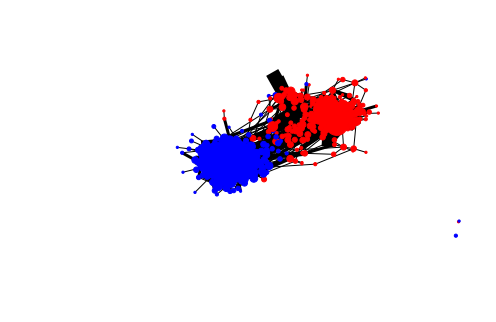

In [12]:
import fa2
import matplotlib.pyplot as plt

forceatlas2 = fa2.ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=0,

    # Performance
    jitterTolerance=.01,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio= 2000,
    strongGravityMode=True,
    gravity=10.0,
    # Log
    verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(rt_nonDirgraph,
                                                    pos=None,
                                                    iterations=4000)

#We use this list to ease the coloring of nodes
rep = list()
for node in rt_nonDirgraph:
    if rt_nonDirgraph.node[node]['party'].item() == 'Republican':
        rep.append(node)

degrees = {}
for node, degree in nx.degree(rt_graph):
    degrees[node] = degree
    
node_colors = ["red" if n in rep
               else 'blue' for n in rt_nonDirgraph.nodes()]

weights = {}
for u, v in rt_nonDirgraph.edges:
    weights[(u, v)] = rt_nonDirgraph[u][v]['weight']
    
nx.draw(rt_nonDirgraph,
        positions,
        cmap=plt.get_cmap('jet'),
        #nodelist=degrees.keys(),
        node_size=[v * 5 for v in degrees.values()],
        node_color = node_colors,
        border = 0.1,
        border_color='black',
        overlap = False,
        width = [w for w in weights.values()],
        with_labels=False)
plt.show()

- Compare the network of Retweets with the network of Wikipedia pages (Week 5, exercise 2). Do you observe any difference? How do you explain them?
    - _There are two main differences we find in this network compared to the one using Wikipedia:_
        - _Firstly, some of the nodes are not connected to others. This can be because they never retweeted any content of because their content was retweeted but they are not members of the congress._
        - _Secondly, there as a much clear association of the nodes within their parties. We can see that most of the nodes are connected to members of the same party._

- Now set the nodes' size proportional to their betweenness centrality. What do you observe?
    - _We observe an uneven distribution of centrality._

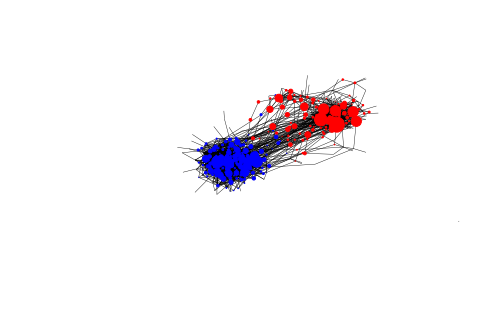

In [16]:
weights = {}
for u, v in rt_nonDirgraph.edges:
    weights[(u, v)] = rt_nonDirgraph[u][v]['weight']
    
nx.draw(rt_nonDirgraph,
        positions,
        cmap=plt.get_cmap('jet'),
        #nodelist=degrees.keys(),
        node_size = [v * 2000 for v in nx.betweenness_centrality(rt_graph).values()],
        node_color = node_colors,
        border = 0.1,
        border_color='black',
        overlap = False,
        width = .4,
        with_labels=False)
plt.show()

- Repeat the point above using eigenvector centrality instead. Is there any difference? Can you explain why?
    - TODO: _NO F IDEA_

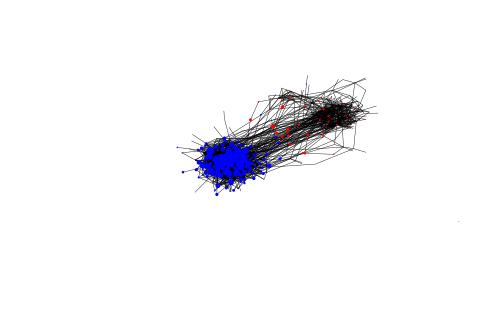

In [18]:
nx.draw(rt_nonDirgraph,
        positions,
        cmap=plt.get_cmap('jet'),
        #nodelist=degrees.keys(),
        node_size = [v * 200 for v in nx.eigenvector_centrality(rt_graph).values()],
        node_color = node_colors,
        border = 0.1,
        border_color='black',
        overlap = False,
        width = .4,
        with_labels=False)
plt.show()

- Who are the three nodes with highest degree within each party? And eigenvector centrality? And betweenness centrality?

In [37]:
rep_deg, dem_deg = [], []

for node in rt_graph.nodes():
    if node in rep:
        rep_deg.append((node,
                        rt_graph.degree(node),
                        nx.eigenvector_centrality(rt_graph, 1000)[node],
                        nx.betweenness_centrality(rt_graph)[node]))
    else:
        dem_deg.append((node,
                        rt_graph.degree(node),
                        nx.eigenvector_centrality(rt_graph, 1000)[node],
                        nx.betweenness_centrality(rt_graph)[node]
                      ))
print('Three nodes with highest degree: \n', sorted(rt_graph.degree(), key=lambda x: x[1], reverse = True)[:3])
print('Three republicans with highest degree: \n', sorted(rep_deg, key=lambda x: x[1], reverse = True)[:3])
print('Three democrats with highest degree: \n', sorted(dem_deg, key=lambda x: x[1], reverse = True)[:3])
print()
print('Three republicans with highest eigenvector centrality: \n', sorted(rep_deg, key=lambda x: x[2], reverse = True)[:3])
print('Three democrats with highest eigenvector centrality: \n', sorted(dem_deg, key=lambda x: x[2], reverse = True)[:3])
print()
print('Three republicans with highest betweenness centrality: \n', sorted(rep_deg, key=lambda x: x[3], reverse = True)[:3])
print('Three democrats with highest betweenness centrality: \n', sorted(dem_deg, key=lambda x: x[3], reverse = True)[:3])

Three nodes with highest degree: 
 [('SpeakerRyan', 93), ('SteveScalise', 79), ('NancyPelosi', 63)]
Three republicans with highest degree: 
 [('SpeakerRyan', 93, 0.0025587742922741226, 0.11323246961084296), ('SteveScalise', 79, 0.008633933995201447, 0.05662851413708352), ('GOPLeader', 42, 9.97716067440768e-05, 0.05571936723063184)]
Three democrats with highest degree: 
 [('NancyPelosi', 63, 0.1971133828155837, 0.06723386821176298), ('repmarkpocan', 63, 0.26551917817644094, 0.03859759146355517), ('WhipHoyer', 58, 0.1580248049186124, 0.045009931292083034)]

Three republicans with highest eigenvector centrality: 
 [('RosLehtinen', 19, 0.05364307596687462, 0.017398734331114118), ('justinamash', 9, 0.030216339180507763, 0.008656876347135186), ('RepSteveStivers', 6, 0.02846289942445271, 0.00898406997301139)]
Three democrats with highest eigenvector centrality: 
 [('repmarkpocan', 63, 0.26551917817644094, 0.03859759146355517), ('RepBeatty', 40, 0.25845197817023935, 0.013876014473026398), ('Re

## TODO

- Plot on the same figure the distribution of outgoing strength for the republican and democratic nodes (e.g. the sum of the weight on outgoing links). Which party is more active in retweeting other members of the house?

## TODO

- Find the 3 members of the republican party that have retweet more often tweets from democratic members. Repeat the measure for the democratic members. Can you explain your results by looking at the Wikipedia pages of these members of the house?

In [43]:
for edge in rt_graph.edges:

    acc = edge[0]
    poster = edge[1]

    if rt_graph.nodes[acc]['party'].item() != rt_graph.nodes[poster]['party'].item():
        rt_graph.nodes[acc]['betrayals'] += 1

In [39]:
betrayers_rep = []
betrayers_dem = []
for node in rt_graph.nodes:
    if rt_graph.nodes[node]['party'].item() == 'Republican':
        betrayers_rep.append((node, rt_graph.nodes[node]['betrayals']))
    else:
        betrayers_dem.append((node, rt_graph.nodes[node]['betrayals']))

In [45]:
print('Top3 republicans who retweeted democrats: \n', sorted(betrayers_rep, key=lambda x: x[1], reverse = True)[:3])
print('Top3 democrats who retweeted republicans: \n', sorted(betrayers_dem, key=lambda x: x[1], reverse = True)[:3])

Top3 republicans who retweeted democrats: 
 [('RepRyanCostello', 5), ('RepMikeTurner', 4), ('TomRooney', 3)]
Top3 democrats who retweeted republicans: 
 [('RepDebDingell', 3), ('RepAnnaEshoo', 2), ('RepCartwright', 2)]


<hr>

### <i> Exercise 3: Community detection.</i>

- Use your favorite method of community detection to find communities in the full house of representatives network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found for the Wikipedia network? Comment on your result.

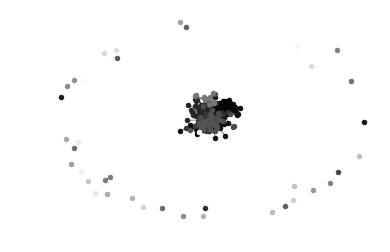

In [73]:
import community
import matplotlib.pyplot as plt

partition = community.best_partition(rt_nonDirgraph)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(rt_nonDirgraph)
count = 0.
for com in set(partition.values()):
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                  if partition[nodes] == com]
    nx.draw_networkx_nodes(rt_nonDirgraph,
                          pos,
                          list_nodes,
                          node_size = 20,
                          node_color = str(count/size))
nx.draw_networkx_edges(rt_nonDirgraph, pos, alpha=.5)
plt.axis('off')
plt.show()

In [52]:
L = len(rt_graph.edges()) #Total amount of edges
L_rep, L_dem = 0, 0

for edge in rt_graph.edges():
    if tw_parties[tw_parties.tw_name == edge[0]].Party.values[0] == tw_parties[tw_parties.tw_name == edge[1]].Party.values[0] == 'Republican':
        L_rep += 1
    elif tw_parties[tw_parties.tw_name == edge[0]].Party.values[0] == tw_parties[tw_parties.tw_name == edge[1]].Party.values[0] == 'Democratic':
        L_dem += 1

K_rep, K_dem = 0, 0
for elt in list(rt_graph.degree()):
    if tw_parties[tw_parties.tw_name == elt[0]].Party.values[0] == 'Republican':
        K_rep += elt[1]
    else:
        K_dem += elt[1]
        
modularity = (L_rep/L - pow(K_rep/(2*L),2)) + (L_dem/L - pow(K_dem/(2*L),2))
print('Modularity = ', modularity)

Modularity =  0.3829349754607726


- Visualize the network, using the Force Atlas algorithm (see Lecture 5, exercise 2). This time assign each node a different color based on their community. Describe the structure you observe.

100%|██████████| 4000/4000 [00:11<00:00, 336.61it/s]


BarnesHut Approximation  took  2.44  seconds
Repulsion forces  took  8.54  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.07  seconds
AdjustSpeedAndApplyForces step  took  0.38  seconds


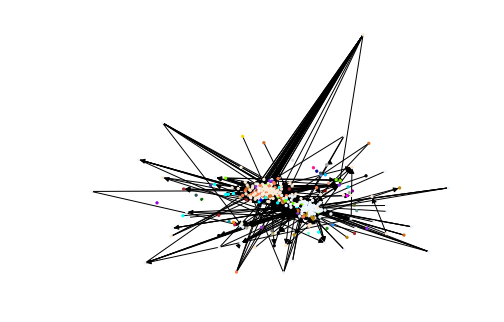

In [55]:
from matplotlib import colors as mcolors

#We create an array with the colors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
com_colors = []
for com in set(partition.values()):
    com_colors.append(list(mcolors.CSS4_COLORS)[com])


positions = forceatlas2.forceatlas2_networkx_layout(rt_graph,
                                                    pos=None,
                                                    iterations=4000)
      
node_colors = [com_colors[partition[node]] for node in rt_graph.nodes]

weights = {}
for u, v in rt_graph.edges:
    weights[(u, v)] = rt_graph[u][v]['weight']
    
nx.draw(rt_graph,
        positions,
        cmap=plt.get_cmap('jet'),
        node_size = 5,
        node_color = node_colors,
        border = 0.1,
        border_color='black',
        overlap = False,
        width = 1,
        with_labels=False)
plt.show()

- Compare the communities found by your algorithm with the parties by creating a matrix $\mathbf{D}$ with dimension $(B \times C$, where $B$ is the number of parties and $C$ is the number of communities. We set entry $D(i,j)$ to be the number of nodes that party $i$ has in common with community $j$. The matrix $\mathbf{D}$ is what we call a confusion matrix.

In [56]:
parties = {(0, 'Republican'), (1, 'Democratic')}
communities = set(partition.values())

D = [[0 for j in range(len(communities))] for i in range(len(parties))]
for p, party in parties:
    for com in communities:
        nodes_ij = [n for n in rt_graph.nodes
                    if(rt_graph.node[n]['party'].item() == party
                       and partition[n] == com)]
        D[p][com] = len(nodes_ij)

- Plot the confusion matrix and explain how well the communities you've detected correspond to the parties. Consider the following questions:
    - Are there any republicans grouped with democrats (and vice versa)?
        - _There can be found some cases colored in a softer tone, although they are not as significant as communities of members from the same party._
    - Does the community detection algorithm sub-divide the parties? Do you know anything about American politics that could explain such sub-divisions? Answer in your own words.

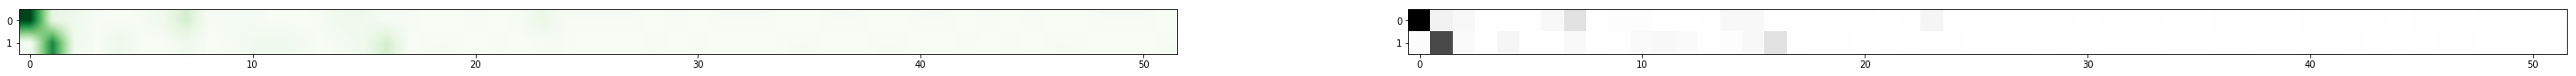

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

a = D

fig = plt.figure(figsize=(50, 50))
ax1 = fig.add_subplot(121)
# Bilinear interpolation - this will look blurry
ax1.imshow(a,
           interpolation='bilinear',
           cmap=cm.Greens)

ax2 = fig.add_subplot(122)
# 'nearest' interpolation - faithful but blocky
ax2.imshow(a,
           interpolation='nearest',
           cmap=cm.Greys)

plt.show()

<hr>

# <u> Part 2: What do republican and democratic members tweet about? </u>

### <i> Exercise 4: TF-IDF of the republican and democratic tweets. </i>

We will create two documents, one containing the words extracted from tweets of republican members, and the other for Democratic members. We will then use TF-IDF to compare the content of these two documents and create a word-cloud. The procedure you should use is exactly the same you used in exercise 2 of week 7. The main steps are summarized below:
- Create two large documents, one for the democratic and one for the republican party. Tokenize the pages, and combine the tokens into one long list including all the pages of the members of the same party.
    - Exclude all twitter handles.
    - Exclude punctuation.
    - Exclude stop words (if you don't know what stop words are, go back and read NLPP1e again).
    - Exclude numbers (since they're difficult to interpret in the word cloud).
    - Set everything to lower case.
    - Compute the TF-IDF for each document.

In [67]:
import nltk
from nltk.corpus import stopwords

for acc in rt_graph.nodes:
    
    f = io.open(path+acc, 'r', encoding='utf-8').read()
    
    #Remove Twitter handles
    words = nltk.word_tokenize(f)
    words = [w for w in words
             if not re.search(r"(RT)((?:\b\W@(\w+))+)|@|RT|http|amp", w)]
    words = [w.lower() for w in words]
    words = [w for w in words 
             if w not in stopwords.words('english')]
    words = [w for w in words
             if not re.search(r'[.,\/#!?$%\^&\*;:{}=\-\—_`´’~()\']', w)]
    words = [w for w in words
             if not re.search(r'\s|\d+(\.\d+)?', w)]
    
    #divide Republicans and Democrats
    if rt_graph.node[acc]['party'].item() == 'Republican':
        file = open("data/republicans.txt","w")
        file.write(" ".join(words))
    else:
        file = open("data/democrats.txt","w")
        file.write(" ".join(words))
    file.close()

- Now, create word-cloud for each party. Are these topics less "boring" than the wikipedia topics from a few weeks ago? Why? Comment on the results.
    - _The topics are more up-to-date thus Twitter is the main channel of communication used by politicians nowadays to keep the citizens informed. Wikipedia's words were related to general information of the members of the house, probably writen by a third person._
    
    _As a reminder, the words that appeared using Wikipedia as our source were district, committee, senate, ..._

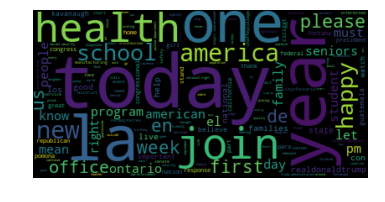

In [71]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

dem = open("data/democrats.txt","r").read()
dem_words = nltk.word_tokenize(dem)
dem_text = nltk.Text(dem_words)

rep = open("data/republicans.txt","r").read()
rep_words = nltk.word_tokenize(rep)
rep_text = nltk.Text(rep_words)

def drawWordCloud(text):
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

drawWordCloud(dem)

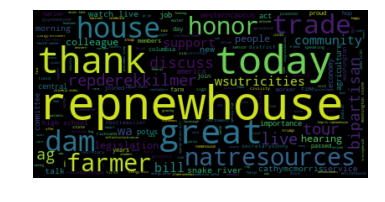

In [72]:
drawWordCloud(rep)

<hr>

# <u> Part 3: Sentiment analysis</u>

### <i> 
Exercise 5: Sentiment over the Twitter data.